In [1]:
2251262592%15+1

13

In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet("/content/drive/MyDrive/Draft/TimeSeries/Data/AMZN-MINUTES1.parquet")

In [4]:
df

,open,high,low,close,vol
2010-01-04 17:30:00,136.1500,136.40,135.76,135.870,61657
2010-01-04 17:31:00,135.9399,136.07,135.75,135.770,68212
2010-01-04 17:32:00,135.8680,135.88,135.40,135.400,44408
2010-01-04 17:33:00,135.4050,135.63,135.32,135.320,75774
2010-01-04 17:34:00,135.3400,135.51,135.34,135.385,33723
...,...,...,...,...,...
2020-11-25 23:46:00,3189.3100,3189.31,3189.31,3189.310,100
2020-11-25 23:47:00,3189.1200,3189.74,3189.12,3189.740,300
2020-11-25 23:48:00,3187.3350,3187.34,3185.00,3185.000,300
2020-11-25 23:49:00,3184.7600,3184.98,3184.76,3184.980,300


In [5]:
import pandas as pd
import pickle


# Đảm bảo index là DatetimeIndex
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ====== 2. Resample dữ liệu thành các tầng ======

# Minute-level (gốc)
df_minute = df.copy()

# Hourly-level
df_hour = df.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'vol': 'sum'
}).dropna()

# Daily-level
df_day = df.resample('1D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'vol': 'sum'
}).dropna()

# ====== 3. Tạo cấu trúc dict ======
multi_resolution_data = {
    'minute': df_minute,
    'hour': df_hour,
    'day': df_day
}

# ====== 4. Hàm tạo chuỗi input/output (windowing) ======
def create_sequences(df, input_len, output_len, target_col='close'):
    sequences = []
    data = df[[target_col]].values
    for i in range(len(data) - input_len - output_len + 1):
        seq_x = data[i : i + input_len]
        seq_y = data[i + input_len : i + input_len + output_len]
        sequences.append((seq_x, seq_y))
    return sequences

# ====== 5. Tạo chuỗi cho từng tầng ======
sequences = {
    'minute': create_sequences(multi_resolution_data['minute'], input_len=60, output_len=10),
    'hour': create_sequences(multi_resolution_data['hour'], input_len=24, output_len=6),
    'day': create_sequences(multi_resolution_data['day'], input_len=20, output_len=5)
}

# ====== 6. (Tùy chọn) Lưu lại toàn bộ dữ liệu đa tầng ======
with open("/content/drive/MyDrive/Draft/multi_resolution_dataset.pkl", "wb") as f:
    pickle.dump(sequences, f)

print("✅ Hoàn tất. Đã sinh dữ liệu multi-resolution cho Transformer.")


<ipython-input-5-7c85b97bd02a>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df.resample('1H').agg({


✅ Hoàn tất. Đã sinh dữ liệu multi-resolution cho Transformer.


In [6]:
import pickle

# Đường dẫn đến file
file_path = '/content/drive/MyDrive/Draft/multi_resolution_dataset.pkl'

# Đọc file pickle
with open(file_path, 'rb') as f:
    sequences = pickle.load(f)

# Kiểm tra dữ liệu
for resolution in sequences:
    print(f"{resolution}: {len(sequences[resolution])} sequences")


minute: 980555 sequences
hour: 19048 sequences
day: 2750 sequences


In [7]:
# In số mẫu ở từng tầng
for res in sequences:
    sample = sequences[res][0]
    print(f"{res.upper()} - total samples: {len(sequences[res])}")
    print(f"  X shape: {sample[0].shape}, Y shape: {sample[1].shape}")


MINUTE - total samples: 980555
  X shape: (60, 1), Y shape: (10, 1)
HOUR - total samples: 19048
  X shape: (24, 1), Y shape: (6, 1)
DAY - total samples: 2750
  X shape: (20, 1), Y shape: (5, 1)


In [9]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

with open('/content/drive/MyDrive/Draft/multi_resolution_dataset.pkl', 'rb') as f:
    multi_res_data = pickle.load(f)



In [10]:
class MultiResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, multi_res_data):
        self.minute = multi_res_data['minute']
        self.hour = multi_res_data['hour']
        self.day = multi_res_data['day']

        min_len = min(len(self.minute), len(self.hour), len(self.day))
        self.minute = self.minute[:min_len]
        self.hour = self.hour[:min_len]
        self.day = self.day[:min_len]

    def __len__(self):
        return len(self.minute)

    def __getitem__(self, idx):
        # Giả sử mỗi phần tử của từng tầng là tuple (input_seq, target_seq)
        x_min, y_min = self.minute[idx]
        x_hr, y_hr = self.hour[idx]
        x_day, y_day = self.day[idx]

        return (
            torch.tensor(x_min, dtype=torch.float32),
            torch.tensor(x_hr, dtype=torch.float32),
            torch.tensor(x_day, dtype=torch.float32),
            torch.tensor(y_min, dtype=torch.float32),
            torch.tensor(y_hr, dtype=torch.float32),
            torch.tensor(y_day, dtype=torch.float32),
        )


In [11]:
import torch.nn as nn

class MultiTaskTransformerGaussian(nn.Module):
    def __init__(self, input_dim=1, d_model=64, output_len=6, nhead=4, num_layers=2):
        super().__init__()

        def build_encoder():
            return nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model, nhead, batch_first=True),
                num_layers=num_layers
            )

        self.embed_min = nn.Linear(input_dim, d_model)
        self.embed_hr = nn.Linear(input_dim, d_model)
        self.embed_day = nn.Linear(input_dim, d_model)

        self.tr_min = build_encoder()
        self.tr_hr = build_encoder()
        self.tr_day = build_encoder()

        self.pos_encoding = nn.Parameter(torch.randn(500, d_model))

        fusion_dim = d_model * 3
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_dim, d_model),
            nn.ReLU(),
        )

        # Dự đoán mean và log_sigma cho từng tầng
        self.output_min = nn.Linear(d_model, 2 * output_len)
        self.output_hr  = nn.Linear(d_model, 2 * output_len)
        self.output_day = nn.Linear(d_model, 2 * output_len)

    def forward(self, x_min, x_hr, x_day):
        def encode(x, embed, encoder):
            x = embed(x) + self.pos_encoding[:x.size(1)]
            h = encoder(x)
            return h[:, -1, :]  # Lấy token cuối

        h_min = encode(x_min, self.embed_min, self.tr_min)
        h_hr  = encode(x_hr, self.embed_hr, self.tr_hr)
        h_day = encode(x_day, self.embed_day, self.tr_day)

        h_cat = torch.cat([h_min, h_hr, h_day], dim=-1)
        h_fused = self.fusion_layer(h_cat)

        def decode(head):
            out = head(h_fused)
            mu, log_sigma = out.chunk(2, dim=-1)
            sigma = torch.exp(log_sigma.clamp(-10, 10))
            return mu, sigma

        return decode(self.output_min), decode(self.output_hr), decode(self.output_day)


In [12]:
def gaussian_nll(mu, sigma, y):
    var = sigma ** 2
    return torch.mean(0.5 * torch.log(var) + 0.5 * ((y - mu)**2) / var)


In [5]:
dataset = MultiResolutionDataset(multi_res_data)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
model = MultiTaskTransformerGaussian()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    total_loss = 0
    for x_min, x_hr, x_day, y_min, y_hr, y_day in loader:
        optimizer.zero_grad()
        (mu_min, sigma_min), (mu_hr, sigma_hr), (mu_day, sigma_day) = model(
    x_min, x_hr, x_day
)


        loss = (
    gaussian_nll(mu_min, sigma_min, y_min[:, :6, 0]) +
    gaussian_nll(mu_hr, sigma_hr, y_hr[:, :, 0]) +         # đã đúng size
    gaussian_nll(mu_day[:, :5], sigma_day[:, :5], y_day[:, :, 0])  # cắt model output còn 5 bước
)



        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1
Epoch 1, Loss: 58966.5522
Epoch 2
Epoch 2, Loss: 238.7287
Epoch 3
Epoch 3, Loss: 87.8723
Epoch 4
Epoch 4, Loss: 49.8239
Epoch 5
Epoch 5, Loss: 34.5699
Epoch 6
Epoch 6, Loss: 27.8579
Epoch 7
Epoch 7, Loss: 24.3355
Epoch 8
Epoch 8, Loss: 22.3602
Epoch 9
Epoch 9, Loss: 21.1133
Epoch 10
Epoch 10, Loss: 20.3362


In [7]:
import matplotlib.pyplot as plt
import torch # Import torch if not already imported in this cell or a prior one

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the chosen device
model.to(device)

model.eval()
with torch.no_grad():
    for x_min, x_hr, x_day, y_min, y_hr, y_day in loader:
        # Chỉ lấy 1 batch
        # Move tensors to the chosen device
        x_min = x_min.to(device)
        x_hr = x_hr.to(device)
        x_day = x_day.to(device)
        # Also move the target tensors to the device if you plan to calculate metrics or plot on the device
        # y_min = y_min.to(device)
        # y_hr = y_hr.to(device)
        # y_day = y_day.to(device)


        (mu_min, sigma_min), (mu_hr, sigma_hr), (mu_day, sigma_day) = model(x_min, x_hr, x_day)

        # Chuyển về CPU để vẽ (if plotting)
        # If you moved y tensors to the device, move them back to CPU before converting to numpy
        mu_min = mu_min.cpu().numpy()
        sigma_min = sigma_min.cpu().numpy()
        y_min = y_min.cpu().numpy() # If y_min was on device, this is correct

        mu_hr = mu_hr.cpu().numpy()
        y_hr = y_hr.cpu().numpy() # If y_hr was on device, this is correct

        mu_day = mu_day.cpu().numpy()
        y_day = y_day.cpu().numpy() # If y_day was on device, this is correct

        break  # chỉ lấy 1 batch

Using device: cuda


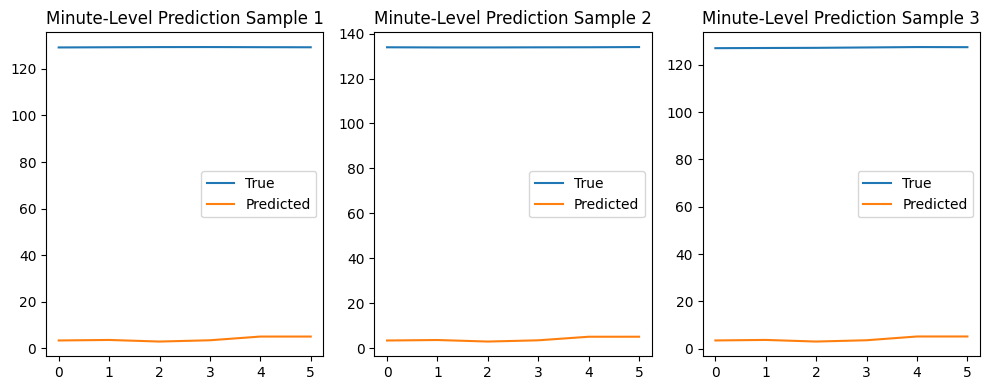

In [8]:
def plot_predictions(pred, true, title):
    plt.figure(figsize=(10, 4))
    for i in range(3):  # vẽ 3 chuỗi đầu tiên
        plt.subplot(1, 3, i + 1)
        plt.plot(true[i, :6, 0], label='True')
        plt.plot(pred[i], label='Predicted')
        plt.title(f"{title} Sample {i+1}")
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_predictions(mu_min, y_min, "Minute-Level Prediction")
